# Import data

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import sys
import shutil
import glob
import cv2
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from time import time

# Import the necessaries libraries
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()

# Data exploration

We can observe two causes to pneumonia: Bacteria and Virus. We need to distinguish them. Let's dive into the data 

In [2]:
import re
import scipy.ndimage as ndimage

# Get the data

class_labels = ['NORMAL', 'BACTERIA', 'VIRUS']

def process_path(nb_class):
    def f(file_path):
        label = 0 if tf.strings.split(file_path, os.path.sep)[-2]=='NORMAL' else 1

        if label == 1 and nb_class == 3:
            label = 1 if tf.strings.split(file_path, '_')[-2]=='bacteria' else 2
            
        image = tf.io.read_file(file_path)    
        image = tf.image.decode_jpeg(image, channels=1)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [128, 128], method='area')
        image = (image / 255.0)
        return image, label
    return f

def reader_image(path_file, batch_size, nb_class):

    list_ds = tf.data.Dataset.list_files(path_file)
    labeled_ds = list_ds.map(process_path(nb_class))
    
    return labeled_ds.shuffle(100).batch(batch_size).prefetch(1)

train_ds = reader_image('train/*/*.jpeg', 16, 3)
test_ds = reader_image('test/*/*.jpeg', 16, 3)

We put it in numpy format

## Train-validation-test 

In [3]:
from sklearn.model_selection import train_test_split

def get_numpy(ds):
    X, y = [], []
    for images, labels in ds:
        X.append(images)
        y.append(labels)
    X = np.concatenate(X, axis=0)
    X = X.reshape(X.shape[0], -1)
    y = np.concatenate(y, axis=0)
    
    return X, y

X, y = get_numpy(train_ds)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
X_test, y_test = get_numpy(test_ds)

## Sample

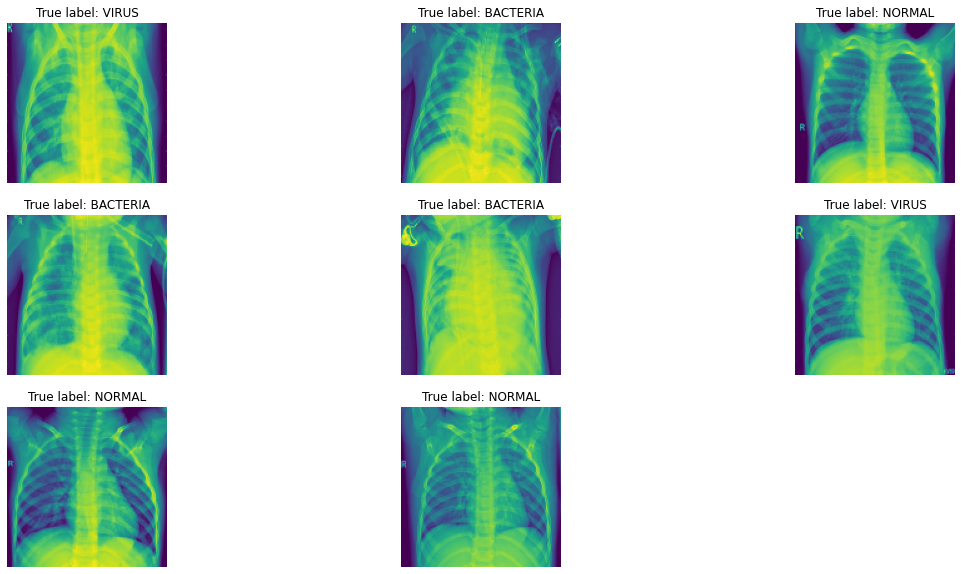

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i,:,:,0].numpy())
        plt.title(f'True label: {class_labels[labels[i].numpy()]}')
        plt.axis("off")

This is clearly an imbalanced data.

In [ ]:
from plotly.subplots import make_subplots

data_train = pd.Series(y_train).value_counts()

normal_train = data_train[0]
bacteria_train = data_train[1]
virus_train = data_train[2]
total_train = normal_train + bacteria_train + virus_train

data_valid = pd.Series(y_valid).value_counts()

normal_valid = data_valid[0]
bacteria_valid = data_valid[1]
virus_valid = data_valid[2]
total_valid = normal_valid + bacteria_valid + virus_valid

fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "pie"}, {"type": "pie"}]], column_titles=['Train proportions', 'validation proportions'])

colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']

fig.add_trace(go.Pie(labels=["Normal", "Bacteria", "Virus"], values=[normal_train, bacteria_train, virus_train]), row=1, col=1)
fig.add_trace(go.Pie(labels=["Normal", "Bacteria", "Virus"], values=[normal_valid, bacteria_valid, virus_valid]), row=1, col=2)

fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update(layout_title_text=f'Class proportions')

pyo.iplot(fig, filename='class proportion')

In [ ]:
import plotly.graph_objects as go

import numpy as np

normal_hist = pd.DataFrame(X_train[y_train==0]).sample(50).values.flatten()
bacteria_hist = pd.DataFrame(X_train[y_train==1]).sample(50).values.flatten()
virus_hist = pd.DataFrame(X_train[y_train==2]).sample(50).values.flatten()

fig = go.Figure()
fig.add_trace(go.Histogram(x=normal_hist, name='Normal',  marker=dict(color='gold')))

fig.add_trace(go.Histogram(x=bacteria_hist, name='Bacteria', marker=dict(color='mediumturquoise')))

fig.add_trace(go.Histogram(x=virus_hist, name='Virus', marker=dict(color='darkorange')))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

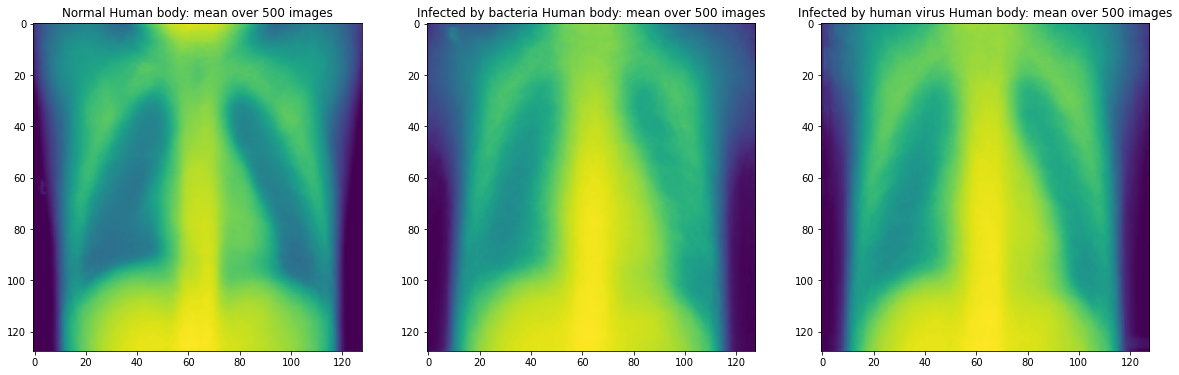

In [6]:
plt.rcParams["figure.figsize"] = (20,18)
ax = plt.subplot(1,3,1)
ax.imshow(pd.DataFrame(X_train[y_train==0]).sample(500).median().values.reshape(128,128))
plt.title('Normal Human body: mean over 500 images')
ax2=plt.subplot(1,3,2)
ax2.imshow(pd.DataFrame(X_train[y_train==1]).sample(500).median().values.reshape(128,128))
plt.title('Infected by bacteria Human body: mean over 500 images')
ax3 = plt.subplot(1,3,3)
ax3.imshow(pd.DataFrame(X_train[y_train==2]).sample(500).median().values.reshape(128,128))
plt.title('Infected by human virus Human body: mean over 500 images')
plt.show()


# Metrics used 

In order to measure our model, we gathered multiple metrics. We defined them:

 - F1 weighted:

$F1 =  \frac{2 (precision \times recall)}  {(precision + recall)}$

In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting depending on the average parameter.

It is a good metrics to compare with other model as it gives a 

 - ROC AUC:

From Wikipedia : 

>The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity, recall or probability of detection[10] in machine learning. The false-positive rate is also known as probability of false alarm[10] and can be calculated as (1 − specificity). It can also be thought of as a plot of the power as a function of the Type I Error of the decision rule (when the performance is calculated from just a sample of the population, it can be thought of as estimators of these quantities).

 - Recall:
 
The recall is the ratio $frac{tp}{(tp + fn)} where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

 - Precision:

The precision is the ratio $\frac{tp}{(tp + fp)}$ where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


A goo understanding of these metrics can help us to choose the best model.

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import OneHotEncoder

def plot_metrics(X_test, y_test, y_pred, model, target_names=['NORMAL', 'BACTERIA', 'VIRUS']):
    
    print('classification report:')
    
    print(classification_report(y_test, y_pred, target_names=labels_name))
    
    y_score = model.predict_proba(X_test)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(target_names)
    for i in range(n_classes):
        y_hot = OneHotEncoder().fit_transform(y_test.reshape(-1,1)).toarray()
        fpr[i], tpr[i], _ = roc_curve(y_hot[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_hot.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure()
    lw = 2
    plt.subplot(121)
    plt.plot(fpr['micro'], tpr['micro'], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    
    ax = plt.subplot(122)
    plot_confusion_matrix(model, X_test, y_test, ax=ax)
    ax.set_xticklabels(target_names)
    ax.set_yticklabels(target_names)
    plt.title('Confusion matrix')
    plt.show()
    

# Curse of dimensionality: Eigenbodies or features importances

Let's take an example to illustrate the high dimensionality problem in machine learning. We take a basic model like logistic regression which is quite quick and represent a good baseline.

We will first train it whith the entire dataset. Then, we will try it on reducted data.

In [8]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

t0 = time()
clf = LogisticRegression()
clf.fit (X_train, y_train)
print("done in %0.3fs" % (time() - t0))
clf.score(X_test, y_test)

dim = PCA(400)
X_train_PCA = dim.fit_transform(X_train)
X_test_PCA = dim.transform(X_test)
t0 = time()
clf = LogisticRegression()
clf.fit (X_train_PCA, y_train)
print("done in %0.3fs" % (time() - t0))
clf.score(X_test_PCA, y_test)

done in 3.640s
done in 0.166s


0.49038461538461536

We can easily see the difference. After reducing the inputs to 400 components, it takes less than 40 times than previous training. You would say that this is not a big gap but this algorithm is $O(nd)$ complexity. However, algorithms like xgboost with a complexity of $O(Kd∥x∥_0logn)$ are really accelerated.

Method: PCA(n_components=5, svd_solver='randomized', whiten=True)
done in 0.926s


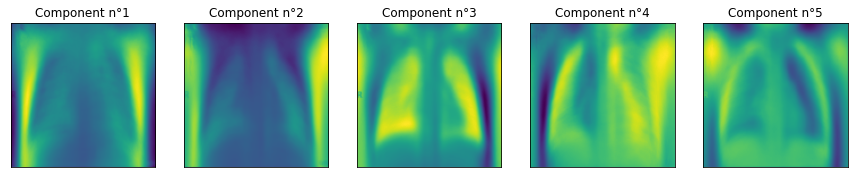

Method: FactorAnalysis(n_components=5)
done in 6.809s


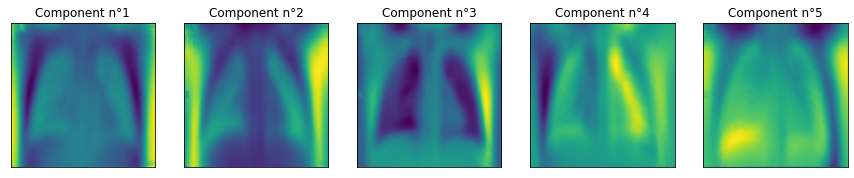

Method: NMF(n_components=5)


C:\Users\gaetd\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



done in 16.076s


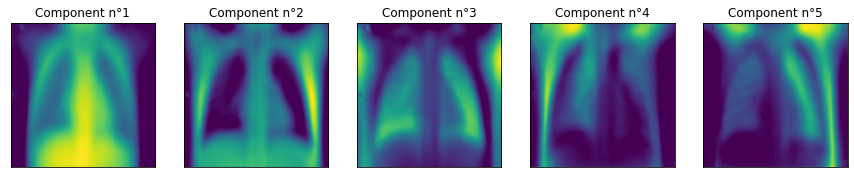

In [15]:
from sklearn.decomposition import KernelPCA, PCA, FactorAnalysis, NMF
from sklearn.pipeline import Pipeline, make_pipeline

plt.rcParams['figure.figsize'] = (15,8)

methods = [PCA(n_components=5, svd_solver='randomized', whiten=True),
           FactorAnalysis(n_components=5),
           NMF(5)]
    
for method in methods:
    t0 = time()
    print(f'Method: {method}')
    method.fit(X_train)
    print("done in %0.3fs" % (time() - t0))
    for component in range(1, 6):
        axe = plt.subplot(1, 5, component)
        plt.title(f'Component n°{component}')
        axe.xaxis.set_visible(False)
        axe.yaxis.set_visible(False)
        plt.imshow(method.components_[component-1,:].reshape(128, 128))
    plt.show()       

Let's see on 2D plan

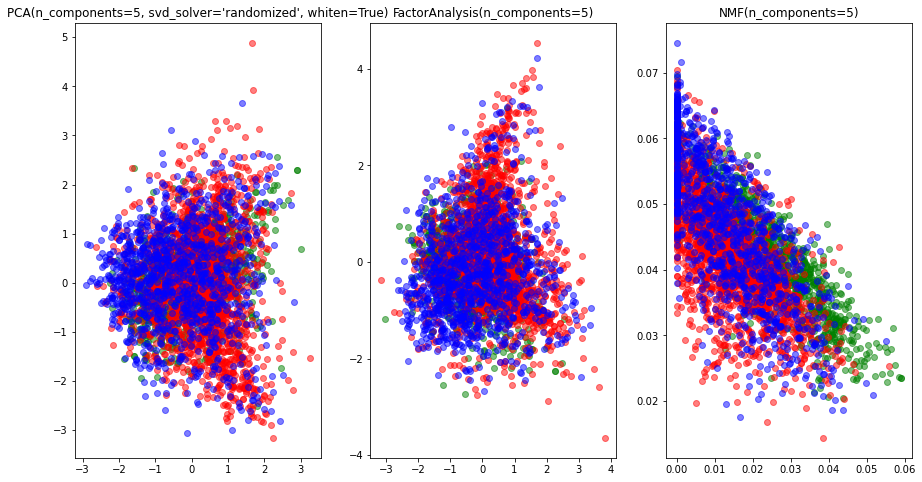

In [16]:
plt.rcParams['figure.figsize'] = (15,8)

for idx, method in enumerate(methods):
    plt.subplot(1, 3, idx+1)
    y = methods[idx].transform(X_train)[:, 0]
    x = methods[idx].transform(X_train)[:, 1]
    plt.scatter(x[y_train==0], y[y_train==0], c='g', alpha=0.5)
    plt.scatter(x[y_train==1], y[y_train==1], c='r', alpha=0.5)
    plt.scatter(x[y_train==2], y[y_train==2], c='b', alpha=0.5)
    plt.title(method)

Example

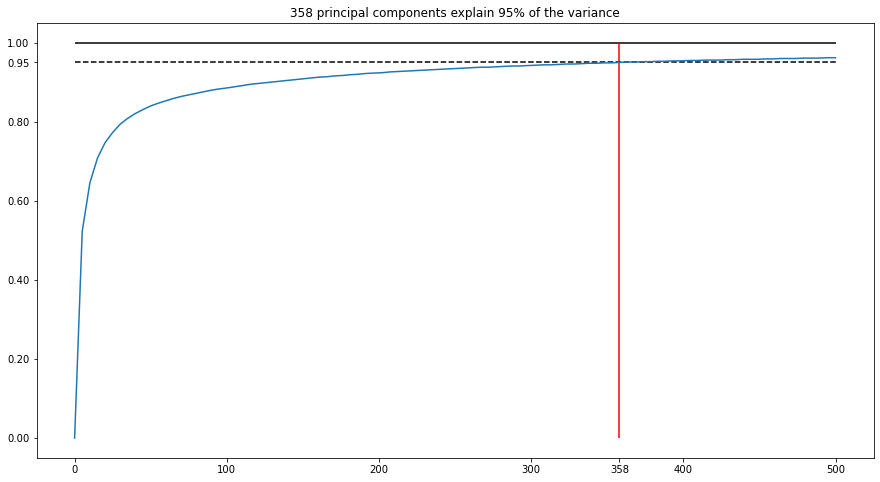

In [69]:
# % of Explained variance with 150 components with PCA

method = PCA(n_components=500, svd_solver='randomized', whiten=True)
method.fit(X_train)

y_fn = lambda x: round(np.sum(method.explained_variance_ratio_[:x]),3)
x = np.linspace(0, 500, 100, dtype='int')
y = np.array([y_fn(i) for i in x])
x_95 = np.argmin(abs(y - 0.95), axis=0)

plt.plot(x, y)
plt.hlines(1, xmin=x.min(), xmax=x.max())
plt.hlines(0.95, xmin=x.min(), xmax=x.max(), linestyles='--')
plt.vlines(x[x_95], ymin=y.min(), ymax=1, color='r')

plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0])
plt.xticks([i for i in range(0, 501, 100)] + [x[x_95]])
plt.title('358 principal components explain 95% of the variance')
plt.show()

In [34]:
t0 = time()
ranking = {'f_classif':pd.Series(f_classif(X_train, y_train)[0]).sort_values(ascending=False).index, 
           'chi2':pd.Series(chi2(X_train, y_train)[0]).sort_values(ascending=False).index}
print('Done in:', time() - t0)

Done in: 0.613332986831665


In [ ]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif, f_classif, chi2

algos = ['f_classif', 'chi2']
ks = [1, 2, 5, 10, 15, 20, 30, 40, 200, 358, 400]

accuracy = pd.DataFrame(index = ks, columns = algos)
for algo in algos:
    for nfeats in ks:
        feats = ranking[algo][:nfeats]

        clf = CatBoostClassifier().fit(
          X_train[:, feats], y_train,
          eval_set = (X_valid[:, feats], y_valid),
          early_stopping_rounds = 20
        )

        accuracy.loc[nfeats, algo] = accuracy_score(
          y_true = y_test, y_pred = clf.predict(X_test[:, feats]))

In [43]:
accuracy

f_classif      chi2
1    0.458333  0.572115
2    0.477564  0.589744
5    0.487179  0.626603
10   0.495192  0.669872
15        0.5  0.679487
20   0.503205  0.690705
30   0.535256  0.676282
40   0.514423  0.692308
200  0.612179  0.713141
358  0.668269  0.708333
400  0.663462  0.706731

In [60]:
chi2(X_train, y_train)[1]

(array([0.03663622, 0.00605341, 0.01709194, ..., 0.1547845 , 0.20234812,
        0.23600621]),
 array([0.98184865, 0.99697787, 0.99149044, ..., 0.92552675, 0.90377571,
        0.88869329]))

In [55]:
ranking['f_classif'][200:]

Int64Index([ 7166, 12544,  6402, 10881, 10750, 11006, 11262, 10494, 12416,
            11774,
            ...
            13080,   132,  4138, 12953, 13585, 13711, 13586, 11026, 13022,
            13584],
           dtype='int64', length=16184)

# Example

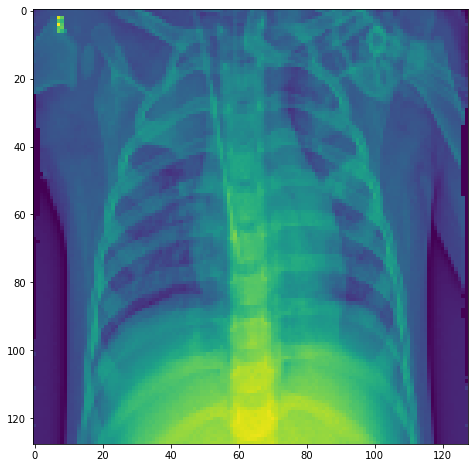

In [66]:
image = X_train.copy()
image[:, ranking['chi2'][:200]] = 0
plt.imshow(image[150].reshape(128, 128))

# Best models

In [237]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

def best_clf(X_train, y_train, X_test, y_test):

    print("Fitting the classifier to the training set")
    t0 = time()
    
    param_grid = [{'C': [1, 1.5, 2]},
                  {'C': [1e3, 1e4, 1e5],
                   'gamma': [0.0001, 0.001, 0.1]},
                  {'n_estimators': [100, 300],
                   'max_depth': [4,  12],
                   'subsample':[0.7]}]
    
    models = [LogisticRegression(),
              SVC(kernel='rbf', class_weight='balanced'),
              XGBClassifier()]
    
    results = pd.DataFrame(columns=['f1_weighted'])
    
    for m, params in zip(models, param_grid):
        
        clf = make_pipeline(PCA(n_components=x[x_95], svd_solver='randomized', whiten=True),
                            GridSearchCV(m, params, cv=3, scoring='f1_weighted', verbose=1))
        clf = clf.fit(X_train, y_train)
        print("done in %0.3fs" % (time() - t0))

        # #############################################################################
        # Quantitative evaluation of the model quality on the test set

        print("Predicting people's names on the test set")
        t0 = time()
        y_pred = clf.predict(X_test)
        print("done in %0.3fs" % (time() - t0))
        
        results.loc[clf, 'f1_weighted'] = clf[1].best_score_
        
    print("Best estimator found by grid search:")
    best_model = results.sort_values('f1_weighted', ascending=False).index[0]
    print(best_model)
    
    return best_model

best_model = best_clf(X_train, y_train, X_test, y_test)

Fitting the classifier to the training set
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. C=1, score=0.745, total=   0.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.731, total=   0.2s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ................................. C=1, score=0.730, total=   0.2s
[CV] C=1.5 ...........................................................


C:\Users\gaetd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ............................... C=1.5, score=0.743, total=   0.2s
[CV] C=1.5 ...........................................................


C:\Users\gaetd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ............................... C=1.5, score=0.730, total=   0.3s
[CV] C=1.5 ...........................................................


C:\Users\gaetd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ............................... C=1.5, score=0.731, total=   0.2s
[CV] C=2 .............................................................


C:\Users\gaetd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ................................. C=2, score=0.742, total=   0.2s
[CV] C=2 .............................................................


C:\Users\gaetd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ................................. C=2, score=0.730, total=   0.2s
[CV] C=2 .............................................................


C:\Users\gaetd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s finished


[CV] ................................. C=2, score=0.733, total=   0.2s
done in 7.869s
Predicting people's names on the test set
done in 0.067s
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=1000.0, gamma=0.0001 ..........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. C=1000.0, gamma=0.0001, score=0.750, total=   8.6s
[CV] C=1000.0, gamma=0.0001 ..........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV] .............. C=1000.0, gamma=0.0001, score=0.736, total=   8.5s
[CV] C=1000.0, gamma=0.0001 ..........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.0s remaining:    0.0s


[CV] .............. C=1000.0, gamma=0.0001, score=0.739, total=   7.6s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............... C=1000.0, gamma=0.001, score=0.772, total=   6.4s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............... C=1000.0, gamma=0.001, score=0.755, total=   6.8s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............... C=1000.0, gamma=0.001, score=0.755, total=   6.1s
[CV] C=1000.0, gamma=0.1 .............................................
[CV] ................. C=1000.0, gamma=0.1, score=0.322, total=   8.5s
[CV] C=1000.0, gamma=0.1 .............................................
[CV] ................. C=1000.0, gamma=0.1, score=0.324, total=   8.5s
[CV] C=1000.0, gamma=0.1 .............................................
[CV] ................. C=1000.0, gamma=0.1, score=0.320, total=   8.4s
[CV] C=10000.0, gamma=0.0001 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  3.3min finished


done in 216.650s
Predicting people's names on the test set
done in 1.041s
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] max_depth=4, n_estimators=100, subsample=0.7 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, n_estimators=100, subsample=0.7, score=0.757, total=   7.5s
[CV] max_depth=4, n_estimators=100, subsample=0.7 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV]  max_depth=4, n_estimators=100, subsample=0.7, score=0.746, total=   7.7s
[CV] max_depth=4, n_estimators=100, subsample=0.7 ....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s


[CV]  max_depth=4, n_estimators=100, subsample=0.7, score=0.757, total=   7.7s
[CV] max_depth=4, n_estimators=300, subsample=0.7 ....................
[CV]  max_depth=4, n_estimators=300, subsample=0.7, score=0.770, total=  19.8s
[CV] max_depth=4, n_estimators=300, subsample=0.7 ....................
[CV]  max_depth=4, n_estimators=300, subsample=0.7, score=0.755, total=  20.8s
[CV] max_depth=4, n_estimators=300, subsample=0.7 ....................
[CV]  max_depth=4, n_estimators=300, subsample=0.7, score=0.766, total=  20.0s
[CV] max_depth=12, n_estimators=100, subsample=0.7 ...................
[CV]  max_depth=12, n_estimators=100, subsample=0.7, score=0.751, total=  11.7s
[CV] max_depth=12, n_estimators=100, subsample=0.7 ...................
[CV]  max_depth=12, n_estimators=100, subsample=0.7, score=0.752, total=  11.5s
[CV] max_depth=12, n_estimators=100, subsample=0.7 ...................
[CV]  max_depth=12, n_estimators=100, subsample=0.7, score=0.760, total=  12.1s
[CV] max_depth=12,

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.1min finished


done in 233.718s
Predicting people's names on the test set
done in 0.143s
Best estimator found by grid search:
Pipeline(steps=[('pca',
                 PCA(n_components=353, svd_solver='randomized', whiten=True)),
                ('gridsearchcv',
                 GridSearchCV(cv=3,
                              estimator=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                               

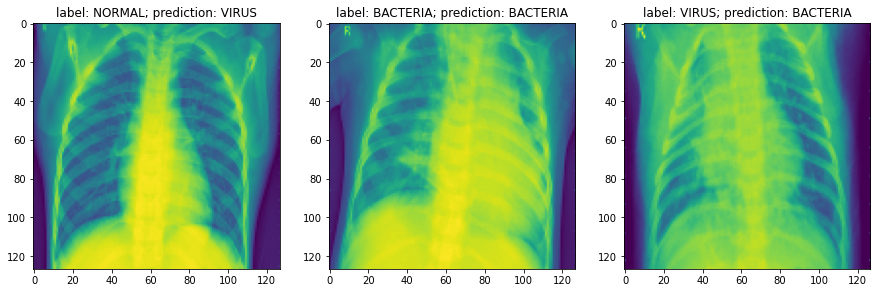

In [310]:
y_pred = best_model.predict(X_test)

for label, name_label in enumerate(labels_name):
    images = X_test[y_test==label, :]
    image = images[0, :]
    predictions = y_pred[y_test==label]
    prediction = predictions[0]
   
    plt.subplot(1, 3, label+1)
    plt.imshow(image.reshape(127, 127))
    plt.title(f'label: {name_label}; prediction: {labels_name[prediction]}')

classification report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.48      0.63       234
    BACTERIA       0.69      0.96      0.80       242
       VIRUS       0.51      0.57      0.54       148

    accuracy                           0.69       624
   macro avg       0.71      0.67      0.66       624
weighted avg       0.74      0.69      0.68       624



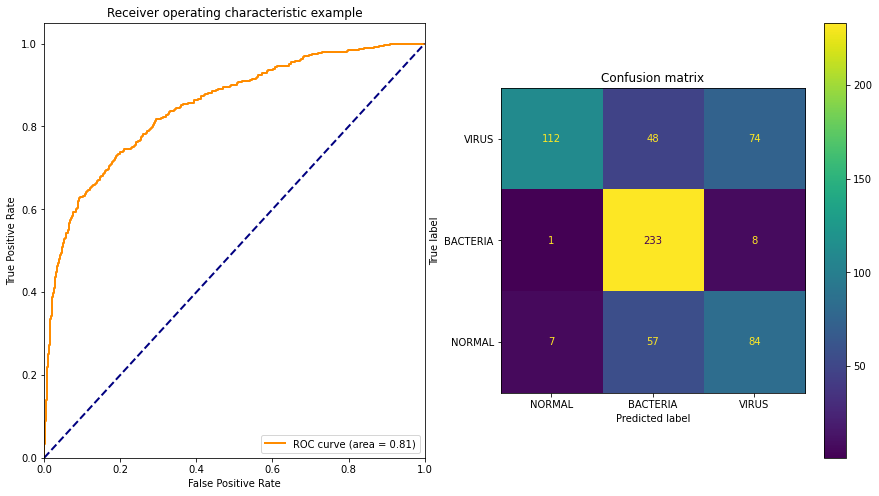

In [309]:
plot_metrics(X_test, y_test, y_pred, best_model)

# Neural network

Neural networks deal very well with high dimensions. We don't need anymore PCA.

## Deterministic model

In [88]:
from tensorflow.keras import layers

# Define our model

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.activation = keras.activations.get(activation)
        self.main_layers = [keras.layers.Conv2D(filters, 3, strides=strides, padding="same",use_bias=False),
                            keras.layers.BatchNormalization(), # Normalize the outputs
                            self.activation,
                            keras.layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False),
                            keras.layers.BatchNormalization()]
        self.skip_layers = [
            keras.layers.Conv2D(filters, 1, strides=strides,padding="same",use_bias=False),
            keras.layers.BatchNormalization()
        ]
        
    def build(self, batch):
        
        pool = batch[-2]
        self.bloc_SE = SEBloc(pool, self.filters)
        
        super().build(batch)
    
    # We don't forget the call method which is called during the training and prediction
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        Z_se = self.bloc_SE(Z)
        Z = Z * Z_se
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
    
class SEBloc(keras.layers.Layer):
    def __init__(self, pool, output_shape, reduction=16, **kwargs):
        super().__init__(**kwargs)
        self.main_layers = [keras.layers.AveragePooling2D(
                                pool_size=pool, strides=1, padding="same"), # pool_size is important, we need a scalar per feature card
                            keras.layers.Dense(pool/reduction, activation='relu'), # embedding
                            keras.layers.Dense(output_shape, activation='sigmoid')] # outputs 
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        return Z
    
    
inputs = tf.keras.Input(shape=(128, 128, 1), dtype="float32")
x = keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")(inputs)
x = keras.layers.experimental.preprocessing.RandomRotation(0.4)(x)
x = tf.keras.layers.experimental.preprocessing.RandomCrop(
    128, 128, seed=None, name=None)(x)
x = tf.keras.layers.experimental.preprocessing.RandomZoom(
    (0.2, 0.3), width_factor=None, fill_mode='reflect',
    interpolation='bilinear', fill_value=0.0)(x)
x = keras.layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(x)
x = keras.layers.Dropout(0.3)(x)

prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    x = ResidualUnit(filters, strides=strides)(x)
    prev_filters = filters

x = keras.layers.GlobalAvgPool2D()(x)
x = keras.layers.Flatten()(x)
output = keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs, output)


In [78]:
import numpy as np # linear algebra
import pandas as pd
from tqdm import tqdm
from glob import glob
from keras.layers import *
from keras.models import *
from keras.utils import *
import numpy as np
import os

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / normal)*(total)/2.0 
weight_for_1 = (1 / bacteria)*(total)/2.0
weight_for_2 = (1 / virus)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

def Residual_Unit(input_tensor, nb_of_input_channels, max_dilation, number_of_units):
    
    for i in range(number_of_units):
        x1 = Conv2D(nb_of_input_channels*2, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(input_tensor)
        x1 = BatchNormalization()(x1)

        a = []

        for i in range(1, max_dilation+1):
            temp = DepthwiseConv2D( kernel_size=(3,3), dilation_rate = (i,i), padding = 'same', activation= 'relu')(x1)
            temp = BatchNormalization()(temp)
            a.append(temp)

        x = Concatenate(axis= -1)(a)
        x = Conv2D(nb_of_input_channels, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(x)
        x = BatchNormalization()(x)

        x = Add()([x, input_tensor])

        input_tensor = x
  
    return x


def Shifter_Unit(input_tensor, nb_of_input_channels, max_dilation):
    x1 = Conv2D(nb_of_input_channels*4, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(input_tensor)
    x1 = BatchNormalization()(x1)

    a = []

    for i in range(1, max_dilation+1):
        temp = DepthwiseConv2D( kernel_size=(3,3), dilation_rate = (i,i), padding = 'same', activation= 'relu')(x1)
        temp = MaxPool2D(pool_size=(2,2))(temp)
        temp = BatchNormalization()(temp)
        a.append(temp)

    x = Concatenate(axis= -1)(a)

    x = Conv2D(nb_of_input_channels*2, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(x)
    x = BatchNormalization()(x)

    return x


def Network128(input_shape, nb_class, depth):
    xin = tf.keras.Input(shape= input_shape)
    
    x = keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")(xin)
    x = keras.layers.experimental.preprocessing.RandomRotation(0.4)(x)

    x = Conv2D(16, kernel_size = (5,5), strides= (1,1), padding = 'same', activation='relu')(xin)
    x = BatchNormalization()(x)

    x = Conv2D(32, kernel_size = (3,3), strides= (2,2), padding = 'same', activation='relu')(x)
    x = BatchNormalization()(x)

    ##Max Dilation rate will be vary in the range (1,5). 

    # Max Dilation rate is 5 for tensor (64x64x32)
    x = Residual_Unit(input_tensor=x, nb_of_input_channels=32, max_dilation=5, number_of_units=depth)
    x = Shifter_Unit(input_tensor=x, nb_of_input_channels=32, max_dilation=5)


    # Max Dilation rate is 4 for (32x32x64)
    x = Residual_Unit(input_tensor=x, nb_of_input_channels=64, max_dilation=4, number_of_units=depth)
    x = Shifter_Unit(input_tensor=x, nb_of_input_channels=64, max_dilation=4)

    # Max Dilation rate is 3 for (16x16x128)
    x = Residual_Unit(input_tensor=x, nb_of_input_channels=128, max_dilation=3, number_of_units=depth)
    x = Shifter_Unit(input_tensor=x, nb_of_input_channels=128, max_dilation=3)

    # Max Dilation rate is 2 for (8x8x256)
    x = Residual_Unit(input_tensor=x, nb_of_input_channels=256, max_dilation=2, number_of_units=depth)

    x = GlobalAveragePooling2D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    x = Dense(nb_class, activation= 'softmax')(x)

    model = Model(xin, x)

    model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model


model = Network128(input_shape = (128, 128, 1), nb_class = 3, depth = 5)

history = model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks = [reduce_lr], class_weight=class_weight, verbose=1) 

Weight for class 0: 1.94
Weight for class 1: 1.03
Weight for class 2: 1.95
Epoch 1/20
  9/324 [..............................] - ETA: 19:34 - loss: 1.5686 - accuracy: 0.4484

KeyboardInterrupt: 

In [89]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss', min_delta=0, patience=5, verbose=0,
                    mode='auto', baseline=None, restore_best_weights=True
                )

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0, nesterov=False, name='SGD'), metrics=['accuracy'])


# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / normal)*(total)/2.0 
weight_for_1 = (1 / bacteria)*(total)/2.0
weight_for_2 = (1 / virus)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

history = model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks = [reduce_lr], class_weight=class_weight, verbose=1) 

Weight for class 0: 1.94
Weight for class 1: 1.03
Weight for class 2: 1.95
Epoch 1/20
324/324 [==============================] - 156s 441ms/step - loss: 1.7075 - accuracy: 0.3415 - val_loss: 1.3745 - val_accuracy: 0.3396
Epoch 2/20
324/324 [==============================] - 56s 171ms/step - loss: 1.6622 - accuracy: 0.3793 - val_loss: 5.5025 - val_accuracy: 0.3396
Epoch 3/20
324/324 [==============================] - 54s 161ms/step - loss: 1.4045 - accuracy: 0.5360 - val_loss: 1.3838 - val_accuracy: 0.4340
Epoch 4/20
324/324 [==============================] - 54s 163ms/step - loss: 1.2872 - accuracy: 0.6031 - val_loss: 1.6168 - val_accuracy: 0.3208
Epoch 5/20
324/324 [==============================] - 55s 166ms/step - loss: 1.1549 - accuracy: 0.6470 - val_loss: 1.6246 - val_accuracy: 0.3396
Epoch 6/20
324/324 [==============================] - 55s 165ms/step - loss: 1.0877 - accuracy: 0.6894 - val_loss: 1.8025 - val_accuracy: 0.3208
Epoch 7/20
 23/324 [=>............................] - 

KeyboardInterrupt: 

In [90]:
model.predict(test_ds)

array([[0.14515208, 0.6095621 , 0.24528587],
       [0.00442633, 0.8018284 , 0.19374532],
       [0.32967845, 0.43278706, 0.2375345 ],
       ...,
       [0.06101577, 0.5525353 , 0.38644895],
       [0.00338531, 0.81785613, 0.17875867],
       [0.05191659, 0.56947833, 0.37860504]], dtype=float32)

In [91]:
test_loss, test_score = model.evaluate(test_ds)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

39/39 [==============================] - 6s 124ms/step - loss: 1.9107 - accuracy: 0.4183
Loss on test set:  1.9107186794281006
Accuracy on test set:  0.41826921701431274


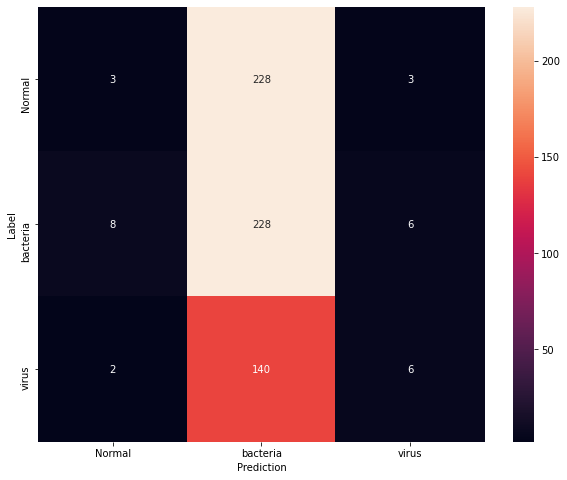

In [95]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(np.concatenate([y for _, y in test_ds], axis=0), np.argmax(model.predict(test_ds), axis=1)) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=['Normal','bacteria','virus'], yticklabels=['Normal','bacteria','virus'], 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## bayesian model

In [ ]:
def analyse_model_prediction(data, true_labels, model, image_num, run_ensemble=False):
    if run_ensemble:
        ensemble_size = 200
    else:
        ensemble_size = 1
    image = data[image_num]
    true_label = true_labels[image_num, 0]
    predicted_probabilities = np.empty(shape=(ensemble_size, 10))
    for i in range(ensemble_size):
        predicted_probabilities[i] = model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    # Show a 95% prediction interval of model predicted probabilities
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(10)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(10)])    
    bar = ax2.bar(np.arange(10), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(10), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(10))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()

In [335]:
import tensorflow_probability as tfp

tfpl = tfp.layers
tfd = tfp.distributions

def nll(y_true, y_pred):    
    return - y_pred.log_prob(y_true)

def get_probabilistic_model(input_shape, loss, optimizer, metrics):
    model = keras.Sequential([
        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        keras.layers.experimental.preprocessing.RandomRotation(0.4),
        keras.layers.experimental.preprocessing.RandomContrast(0.5),
        keras.layers.Conv2D(8, (5,5), activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling2D((6,6)),
        keras.layers.Flatten(),
        keras.layers.Dense(tfpl.OneHotCategorical.params_size(3)),
        tfpl.OneHotCategorical(3, convert_to_tensor_fn = tfd.Distribution.mode)
    ])
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

tf.random.set_seed(0)
probabilistic_model = get_probabilistic_model(
    input_shape=(600, 600, 1), 
    loss=nll, 
    optimizer=keras.optimizers.RMSprop(), 
    metrics=['accuracy']
)

probabilistic_model.fit(train_ds, epochs=5)



Epoch 1/5
21/81 [======>.......................] - ETA: 49s - loss: 3.2861 - accuracy: 0.2787

KeyboardInterrupt: 

# Fine tuning

In [80]:
IMG_SHAPE = (128, 128, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

inputs = tf.keras.Input(shape=(128, 128, 1))
x = keras.layers.Concatenate()((inputs,inputs,inputs))
x = base_model(x, training=False)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(x)
outputs = keras.layers.Dense(3, activation="softmax")(feature_batch_average)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / normal)*(total)/2.0 
weight_for_1 = (1 / bacteria)*(total)/2.0
weight_for_2 = (1 / virus)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

history = model.fit(train_ds,
                    epochs=5,
                    validation_data=valid_ds,
                    class_weight=class_weight)

Weight for class 0: 1.94
Weight for class 1: 1.03
Weight for class 2: 1.95
Epoch 1/5
324/324 [==============================] - 111s 311ms/step - loss: 10.3760 - accuracy: 0.3272 - val_loss: 4.6367 - val_accuracy: 0.3774
Epoch 2/5
324/324 [==============================] - 95s 283ms/step - loss: 6.6265 - accuracy: 0.3447 - val_loss: 1.1205 - val_accuracy: 0.3774
Epoch 3/5
139/324 [===========>..................] - ETA: 1:13 - loss: 9.5483 - accuracy: 0.3302

KeyboardInterrupt: 